<a href="https://colab.research.google.com/github/sraminics/CMPE297/blob/master/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Reading and Labeling the Data

In [1]:
import pandas as pd
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
if not(os.path.exists('/content/train')):
    print('Unzipping train.zip...')
    !unzip -q '/content/drive/My Drive/CMPE297/dog-breed-identification/train.zip'
    print('Unzipping test.zip...')
    !unzip -q '/content/drive/My Drive/CMPE297/dog-breed-identification/test.zip'
    print('finished')
else:
    print('Already loaded') 

Unzipping train.zip...
Unzipping test.zip...
finished


In [3]:
labels_raw = pd.read_csv("/content/drive/My Drive/CMPE297/dog-breed-identification/labels.csv")
labels_raw['id'] = labels_raw['id']+'.jpg'
labels_raw.head()




,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
labels = labels_raw


imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )


train_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)


val_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)


# test_datagen=ImageDataGenerator(rescale=1./255.)
# test_generator=test_datagen.flow_from_dataframe(
# dataframe=test_labels,
# directory="content/test/",
# x_col="id",
# y_col=None,
# batch_size=32,
# seed=42,
# shuffle=False,
# class_mode=None,
# target_size=(32,32))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [5]:
from keras.applications import ResNet50V2

resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet.trainable=False


Using TensorFlow backend.







94674944/94668760 [==============================] - 1s 0us/step


In [6]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [7]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

model = models.Sequential()
model.add(resnet)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='sigmoid'))

model.compile(
    optimizer='adam', 
    loss=losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 49,286,008
Trainable params: 25,721,208
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      epochs=10,
      validation_data=val_generator,
      validation_steps=STEP_SIZE_VALID)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
255/255 [==============================] - 175s 687ms/step - loss: 6.8494 - acc: 0.0148 - val_loss: 6.6237 - val_acc: 0.0154
Epoch 2/10
255/255 [==============================] - 169s 663ms/step - loss: 6.7292 - acc: 0.0123 - val_loss: 7.2931 - val_acc: 0.0094
Epoch 3/10
255/255 [==============================] - 168s 657ms/step - loss: 6.8824 - acc: 0.0123 - val_loss: 7.5689 - val_acc: 0.0169
Epoch 4/10
255/255 [==============================] - 167s 656ms/step - loss: 6.9073 - acc: 0.0103 - val_loss: 7.6280 - val_acc: 0.0263
Epoch 5/10
255/255 [==============================] - 165s 646ms/step - loss: 6.8556 - acc: 0.0089 - val_loss: 7.0547 - val_acc: 0.0139
Epoch 6/10
255/255 [==============================] - 166s 650ms/step - loss: 6.7018 - acc: 0.0086 - val_loss: 7.3774 - val_acc: 0.0154
Epoch 7/10
255/255 [==============================] - 166s 652ms/step - loss: 5.6029 - a

In [0]:
model.save('dog_breads.h5')

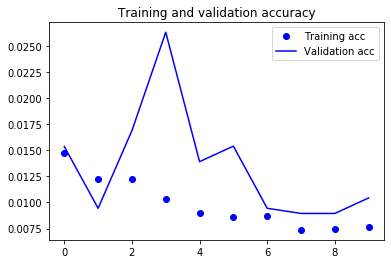

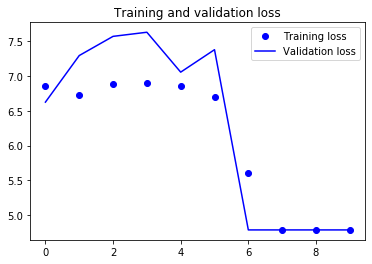

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()